# Exploring Movie Data to Provide Business Recommendations


<img src="nicole-kidman-nicole.gif" width="750" align="center">



## The Problem
### Hollywood is highly satured. How would a newcomer make movies that make money?

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. 

Explore the data to determine what types of films are currently doing the best at the box office. Translate these findings into actionable insights a company like Microsoft can use.

## The Analysis

### Import the data

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
conn = sqlite3.connect("zippedData/im.db")
import seaborn as sns

When importing from the IMDB dataset, we only want primary_title, runtime_minutes, and genres since these will be most relevant to our recommendations.

In [160]:
movie_basics = pd.read_sql("""
SELECT primary_title, runtime_minutes, genres
  FROM movie_basics
""", conn)
movie_gross = pd.read_csv('zippedData/tn.movie_budgets.csv', delimiter = ",")

### Preview the Data

Let's pull up some of the data we just imported.

In [161]:
movie_basics.head()

,primary_title,runtime_minutes,genres
0,Sunghursh,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,114.0,"Biography,Drama"
2,The Other Side of the Wind,122.0,Drama
3,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy"


In [162]:
movie_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Cleaning the Data

To convert the budget and gross columns, I removed the $ and , characters and converted them to integers so we can determine profit as described above. I also want to create a column for year of release.

In [163]:
#removing the dollar signs

movie_gross["production_budget"]=movie_gross["production_budget"].str.replace('$', '')
movie_gross["domestic_gross"]=movie_gross["domestic_gross"].str.replace('$', '')
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].str.replace('$', '')

#removing the commas
movie_gross["production_budget"]=movie_gross["production_budget"].str.replace(',', '')
movie_gross["domestic_gross"]=movie_gross["domestic_gross"].str.replace(',', '')
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].str.replace(',', '')

#converting to intgers
movie_gross["production_budget"]=movie_gross["production_budget"].astype(int)
movie_gross["domestic_gross"] =movie_gross["domestic_gross"].astype(int)
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].astype(int)

#creating column for year of release
movie_gross["year"] = movie_gross["release_date"].apply(lambda x:int(x[-4:]))

In [171]:
movie_gross

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018
5778,79,"Apr 2, 1999",Following,6000,48482,240495,1999
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015


If we look at the years represented in our datasets, we see that the middle 50 is between 2000 and 2012. The set ranges between 1915 and 2019. It makes the most sense to focus on movies made between 1999 and 2020. That way we include the major clusterings in our datset and also retain validity since a movie made in the last 20 or so years has more bearing on the movies that are successful today than a movie made before then. So let's remove the rows from before 1999.

In [172]:
movie_gross["year"].describe()

count    4568.000000
mean     2008.905429
std         5.547832
min      1999.000000
25%      2004.000000
50%      2009.000000
75%      2014.000000
max      2020.000000
Name: year, dtype: float64

In [173]:
movie_gross = movie_gross.loc[movie_gross["year"] >= 1999]

I also don't want any rows where "worldwide_gross" or "domestic_gross" is $0 since those are null values and won't help me determine whether this film is profitable or not. Let's see if the number of movies that are missing both those values is the same as the ones missing just one.

In [174]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) | (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


In [175]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) & (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
670,71,"Aug 30, 2019",PLAYMOBIL,75000000,0,0,2019
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


Since there are films missing one or both values for "domestic_gross" and "worldwide_gross", we're going to need to first remove all the rows that are missing both these values. Then we'll need to create two different data frames for domestic and worldwide so we don't lose important data. 

mg_clean will be our new dataframe that only contains values that have values for at least one of "domestic_gross" or "worldwide_gross."

In [176]:
mg_clean=movie_gross.loc[(movie_gross["domestic_gross"] != 0) | (movie_gross["worldwide_gross"] != 0)]

Further analysis shows that while some rows are missing domestic_gross, none are missing worldwide_gross. So mg_clean can function as our worldwide_gross dataframe, but we still need a new one for domestic.

In [177]:
mg_clean.loc[mg_clean["domestic_gross"] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
619,20,"Jan 22, 2019",Renegades,77500000,0,1521672,2019
820,21,"Oct 26, 2018",Air Strike,65000000,0,516279,2018
1325,26,"Dec 31, 2012",Foodfight!,45000000,0,73706,2012
1367,68,"Dec 31, 2006",Les BronzÃ©s 3: amis pour la vie,42000000,0,83833602,2006
...,...,...,...,...,...,...,...
5590,91,"Mar 24, 2015",Along the Roadside,250000,0,3234,2015
5652,53,"Dec 31, 2015",Lumea e a mea,168000,0,29678,2015
5661,62,"Dec 31, 2013",Speak No Evil,150000,0,32927,2013
5705,6,"Dec 31, 2011",Absentia,70000,0,8555,2011


In [178]:
mg_clean["worldwide_gross"].value_counts().sort_index()

26            1
176           1
401           1
423           1
450           1
             ..
1518722794    1
1648854864    1
2048134200    1
2053311220    1
2776345279    1
Name: worldwide_gross, Length: 4226, dtype: int64

In [179]:
mgc_w=mg_clean.copy().drop(columns=["id", "domestic_gross"])
mgc_d=mg_clean.loc[mg_clean["domestic_gross"] > 0].drop(columns=["id", "worldwide_gross"])

In [180]:
mgc_w.head()

,release_date,movie,production_budget,worldwide_gross,year
0,"Dec 18, 2009",Avatar,425000000,2776345279,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,149762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,1403013963,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [181]:
mgc_d.head()

,release_date,movie,production_budget,domestic_gross,year
0,"Dec 18, 2009",Avatar,425000000,760507625,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,2017


Now it's time to create new columns for profits (gross - budget), divide them by 1,000,000 to get smaller numbers, and remove the gross columns.

In [182]:
#converting to profits
mgc_w["worldwide_profits"] = mgc_w["worldwide_gross"] - mgc_w["production_budget"]
mgc_d["domestic_profits"] = mgc_d["domestic_gross"] - mgc_d["production_budget"]


#dividing by a million
mgc_w["worldprofits_inmillions"] = mgc_w["worldwide_profits"] / 1000000
mgc_d["domesticprofits_inmillions"] = mgc_d["domestic_profits"]/ 1000000

#removing gross columns
mgc_w=mgc_w.drop(columns = ["worldwide_gross", "worldwide_profits", "production_budget"])
mgc_d=mgc_d.drop(columns = ["domestic_gross", "domestic_profits", "production_budget"])

In [183]:
mgc_w

,release_date,movie,year,worldprofits_inmillions
0,"Dec 18, 2009",Avatar,2009,2351.345279
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011,635.063875
2,"Jun 7, 2019",Dark Phoenix,2019,-200.237650
3,"May 1, 2015",Avengers: Age of Ultron,2015,1072.413963
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,2017,999.721747
...,...,...,...,...
5775,"May 26, 2006",Cavite,2006,0.064644
5776,"Dec 31, 2004",The Mongol King,2004,-0.006100
5778,"Apr 2, 1999",Following,1999,0.234495
5779,"Jul 13, 2005",Return to the Land of Wonders,2005,-0.003662


We can see that "primary_title" in movie_basics is the same as "movie" in movie_gross. 

We're going to merge these dataframes along "primary_title" for movie_basics from IMDB and "movie" from movie_gross from The Numbers to create the new dataframe movie_totals.

In [184]:
mgcw_totals = pd.merge(mgc_w, movie_basics, left_on = "movie", right_on = "primary_title", how = "outer").dropna(subset =["worldprofits_inmillions"])
mgcd_totals = pd.merge(mgc_d, movie_basics, left_on = "movie", right_on = "primary_title", how = "outer").dropna(subset =["domesticprofits_inmillions"])

In [187]:
mgcw_totals.sort_values("worldprofits_inmillions")

,release_date,movie,year,worldprofits_inmillions,primary_title,runtime_minutes,genres
2,"Jun 7, 2019",Dark Phoenix,2019.0,-200.237650,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi"
224,"Mar 11, 2011",Mars Needs Moms,2011.0,-110.450242,Mars Needs Moms,88.0,"Adventure,Animation,Family"
432,"Jun 14, 2019",Men in Black: International,2019.0,-106.900000,Men in Black: International,115.0,"Action,Adventure,Comedy"
445,"Apr 27, 2001",Town & Country,2001.0,-94.635231,NaN,NaN,NaN
495,"Aug 16, 2002",The Adventures of Pluto Nash,2002.0,-92.905005,NaN,NaN,NaN
...,...,...,...,...,...,...,...
77,"Apr 3, 2015",Furious 7,2015.0,1328.722794,Furious 7,137.0,"Action,Crime,Thriller"
33,"Jun 12, 2015",Jurassic World,2015.0,1433.854864,Jurassic World,124.0,"Action,Adventure,Sci-Fi"
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,2015.0,1747.311220,NaN,NaN,NaN
6,"Apr 27, 2018",Avengers: Infinity War,2018.0,1748.134200,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi"


In [188]:
mgcd_totals.sort_values("domesticprofits_inmillions")

,release_date,movie,year,domesticprofits_inmillions,primary_title,runtime_minutes,genres
2,"Jun 7, 2019",Dark Phoenix,2019.0,-307.237650,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi"
13,"Mar 9, 2012",John Carter,2012.0,-201.941321,John Carter,132.0,"Action,Adventure,Sci-Fi"
12,"Jul 2, 2013",The Lone Ranger,2013.0,-185.697885,The Lone Ranger,150.0,"Action,Adventure,Western"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011.0,-169.536125,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy"
31,"May 18, 2012",Battleship,2012.0,-154.766600,Battleship,131.0,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...
26,"May 4, 2012",The Avengers,2012.0,398.279547,The Avengers,143.0,"Action,Adventure,Sci-Fi"
51,"Jun 15, 2018",Incredibles 2,2018.0,408.581744,Incredibles 2,118.0,"Action,Adventure,Animation"
33,"Jun 12, 2015",Jurassic World,2015.0,437.270625,Jurassic World,124.0,"Action,Adventure,Sci-Fi"
50,"Feb 16, 2018",Black Panther,2018.0,500.059566,Black Panther,134.0,"Action,Adventure,Sci-Fi"


Now we have a clean pair of dataframes that tell us movie, profits, and year of release for both worldwide profits and domestic profits. We are missing some values in "primary_title," "runtime_minutes," and "genres," but we'll need to remove these later as needed. It's time to move on to the analysis.

# The Analysis
## When should Microsoft release movies?

Movies are released at key points throughout the year – the summer blockbuster, the Christmas flick. The time of year a movie is released might be critical to its profitability.

I start by creating new dataframes that include month columns which add a month number based on the "release_date" column. I then remove unneded columns and group each dataframe by the average profits.

In [189]:
#adding a months column for our worldwide dataframe and removing unneded column
month_w = mgc_w.copy()
month_w['month']=pd.to_datetime(month_w['release_date']).dt.month
month_w=month_w.drop(columns=["release_date", "movie", "year"])
month_w=month_w.groupby("month").mean().reset_index()

#adding a months column for our domestic dataframe and removing "release_date" column
month_d = mgc_d.copy()
month_d['month']=pd.to_datetime(month_d['release_date']).dt.month
month_d=month_d.drop(columns=["release_date", "movie", "year"])
month_d=month_d.groupby("month").mean().reset_index()

Now we can map the relationship between month of release and profits. The first visualization includes both worldwide (pink) and domestic (green). The second visualization allows us to see jsut domestic profits since worldwide profits dwarfs them.

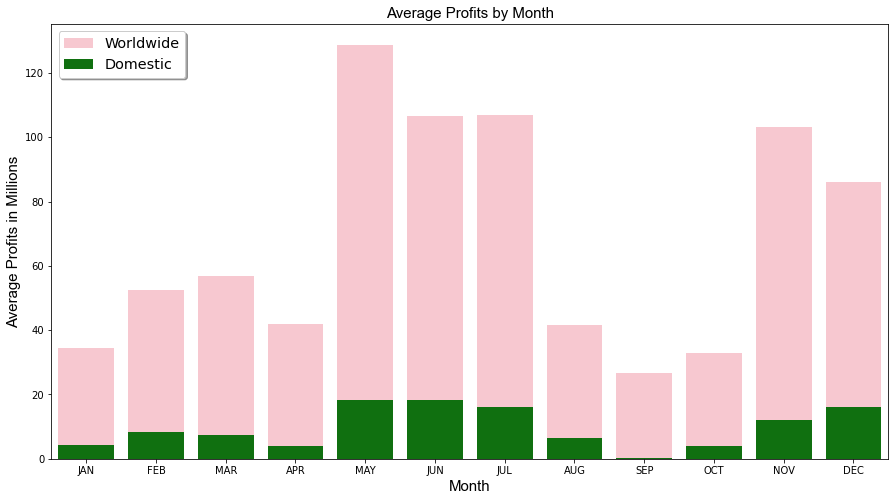

In [190]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=month_w["month"], y=month_w["worldprofits_inmillions"], color='pink', label='Worldwide', ci = None)
ax = sns.barplot(x=month_d["month"], y=month_d["domesticprofits_inmillions"], color='green', label= 'Domestic', ci = None)
ax.set_xlabel('Month', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Month', fontfamily = 'Arial', fontsize = 15)
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

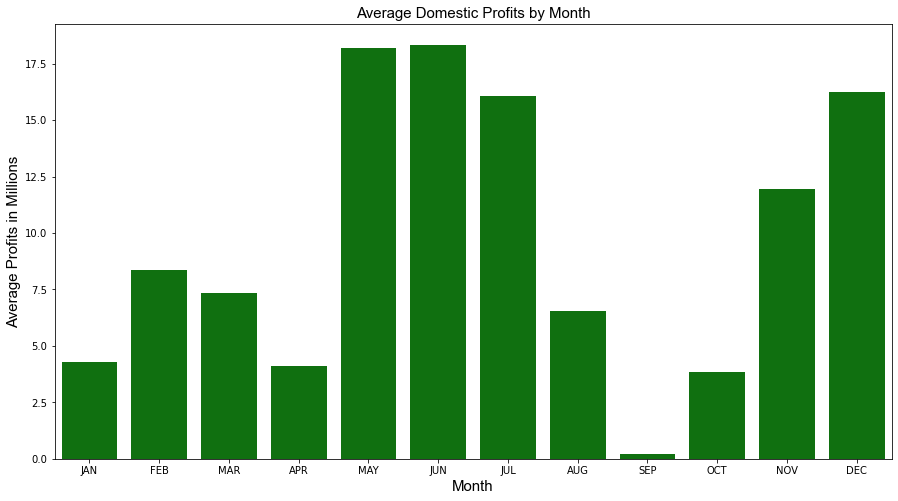

In [191]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=month_d["month"], y=month_d["domesticprofits_inmillions"], color='green', label= 'Domestic', ci = None)
ax.set_xlabel('Month', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Domestic Profits by Month', fontfamily = 'Arial', fontsize = 15)
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']);

#### For both world and domestic releases, it makes sense for Microsoft to release its movies in May, June, and July. 

#### November and December are also good months to release movies. 

#### September is the worst month for a movie release.

## What genres should Microsoft focus on?

There are so many types of films a studio can make. From action to musical, there are so many options and combinations of genres that can yield profits. Which genres are the most profitable?

To get genre information, we need to go back to mgcw_totals and mgcd_totals dataframes. Let's remove all rows where genre isn't listed.

In [198]:
genres_w = mgcw_totals.dropna(subset=["genres"]).drop(columns= ["release_date", "movie", "primary_title", "year", "runtime_minutes"])
genres_d = mgcd_totals.dropna(subset=["genres"]).drop(columns= ["release_date", "movie", "primary_title", "year", "runtime_minutes"])

In some cases, our genres are clustered together. Let's separate them.

In [203]:
genres_w["genres"] = genres_w["genres"].apply(lambda x: str(x).split(","))
genres_w = genres_w.explode('genres')
genres_w=genres_w.groupby("genres").mean().reset_index()
genres_d["genres"] = genres_d["genres"].apply(lambda x: str(x).split(","))
genres_d = genres_d.explode('genres')
genres_d=genres_d.groupby("genres").mean().reset_index()

In [204]:
genres_w

,genres,worldprofits_inmillions
0,Action,129.479941
1,Adventure,209.661590
2,Animation,239.774793
3,Biography,47.377693
4,Comedy,77.012824
5,Crime,41.311379
6,Documentary,46.404557
7,Drama,39.185814
8,Family,106.269885
9,Fantasy,149.148310


Now we can map the relationship between genre and profits. The first visualization maps worldwide profits against genre, the second domestic profits against genre, and the third both against genre.

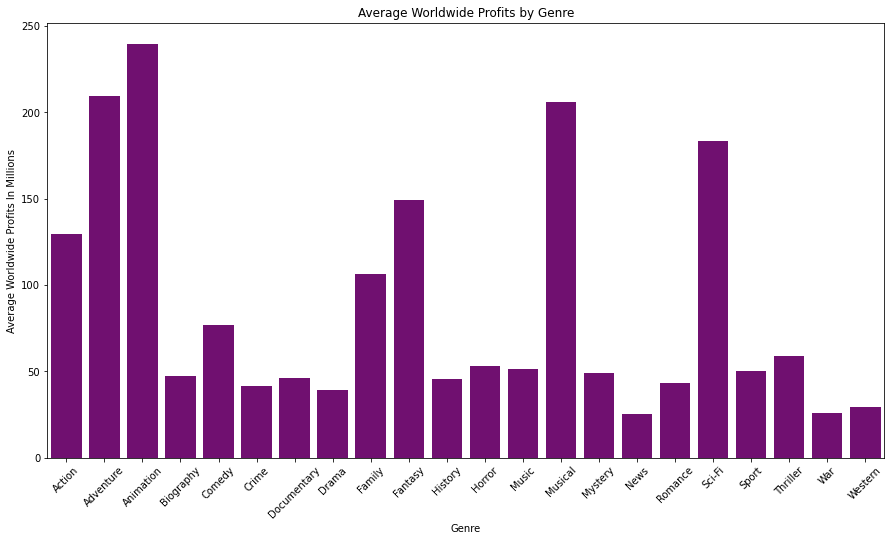

In [205]:
plt.figure(figsize=(15,8))
w = sns.barplot(data=genres_w, x="genres", y="worldprofits_inmillions", color = "purple", ci=None)
w.set(xlabel='Genre',
       ylabel='Average Worldwide Profits In Millions',
       title='Average Worldwide Profits by Genre')
plt.xticks(rotation=45)

plt.show()

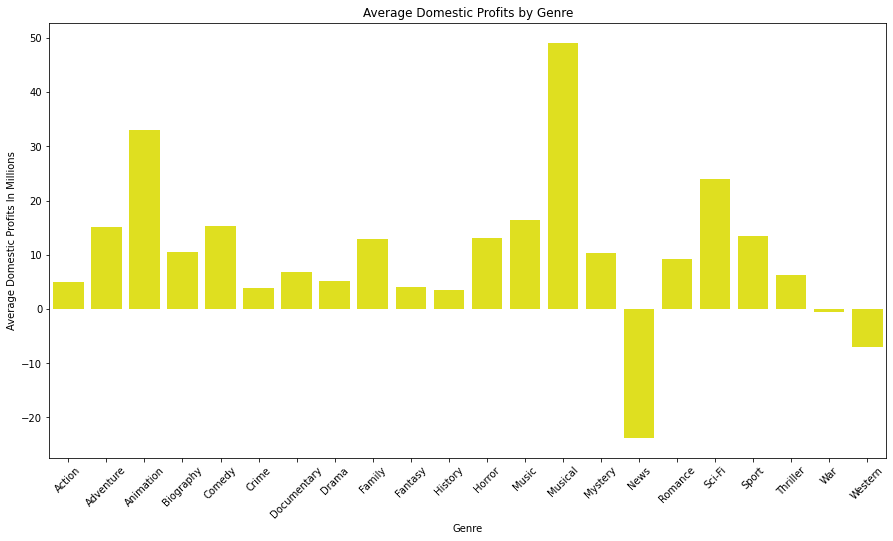

In [206]:
plt.figure(figsize=(15,8))
v = sns.barplot(data=genres_d, x="genres", y="domesticprofits_inmillions", color = "yellow", ci=None)
v.set(xlabel='Genre',
       ylabel='Average Domestic Profits In Millions',
       title='Average Domestic Profits by Genre')
plt.xticks(rotation=45)

plt.show()

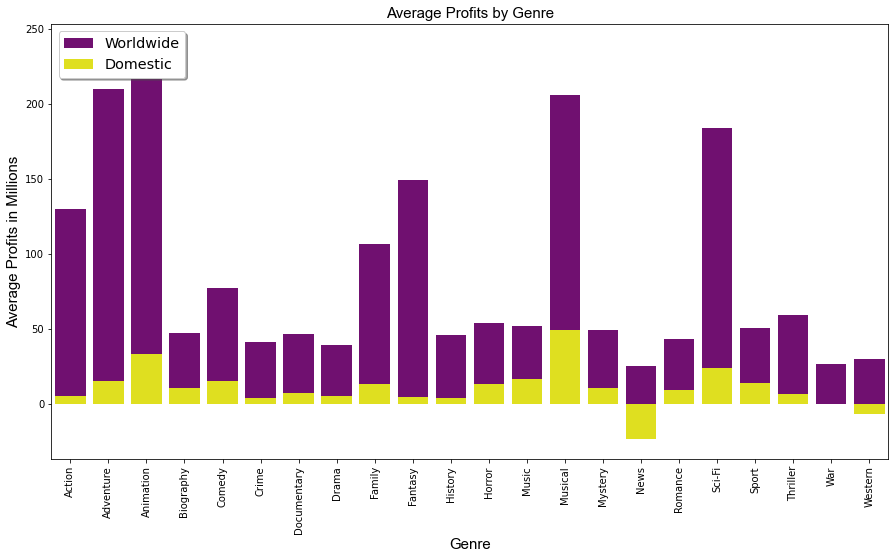

In [210]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=genres_w["genres"], y=genres_w["worldprofits_inmillions"], color='purple', label='Worldwide', ci = None)
ax = sns.barplot(x=genres_d["genres"], y=genres_d["domesticprofits_inmillions"], color='yellow', label= 'Domestic', ci = None)
ax.set_xlabel('Genre', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Genre', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks(rotation=90);

But since genres were clustered in our dataset originally, we don't want to lose data in separating them and only offering suggestions based on that finding. Below are the top clustered genres for worldwide and domestic releases.

In [222]:
world_clusters = mgcw_totals.dropna(subset=["genres"]).drop(columns = ["release_date", "movie", "year", "primary_title",
                                                                      "runtime_minutes"])
world_clusters = world_clusters.groupby("genres").mean().reset_index()
world_clusters.sort_values(by = "worldprofits_inmillions", ascending=False).head(20)

,genres,worldprofits_inmillions
108,"Adventure,Drama,Sport",1122.469910
300,"Fantasy,Romance",1122.469910
292,"Family,Fantasy,Musical",1099.199706
299,"Fantasy,Musical",825.491110
107,"Adventure,Drama,Sci-Fi",524.325409
114,"Adventure,Fantasy",469.544026
14,"Action,Adventure,Sci-Fi",466.673456
241,"Drama,Family,Fantasy",439.551353
237,"Documentary,Thriller",354.683805
102,"Adventure,Drama,Fantasy",334.192689


In [223]:
domestic_clusters = mgcd_totals.dropna(subset=["genres"]).drop(columns = ["release_date", "movie", "year", "primary_title",
                                                                      "runtime_minutes"])
domestic_clusters = domestic_clusters.groupby("genres").mean().reset_index()
domestic_clusters.sort_values(by = "domesticprofits_inmillions", ascending=False).head(20)

,genres,domesticprofits_inmillions
284,"Family,Fantasy,Musical",344.014165
106,"Adventure,Drama,Sport",250.738009
292,"Fantasy,Romance",250.738009
108,"Adventure,Drama,Western",136.243005
291,"Fantasy,Musical",134.191110
191,"Comedy,Romance,Sci-Fi",117.805123
234,"Drama,Family,Fantasy",106.151353
120,"Animation,Comedy,Family",105.428795
25,"Action,Comedy,Documentary",97.229692
145,"Biography,Drama,Musical",90.340174


#### Based on the visualizations, adventure, animation, musical, and sci-fi are all top genres for worldwide releases. While musical, animation, and sci-fi are top for domestic releases.

#### If we focused on clusters, by contrast, we're going to want some combination of adventure, drama, sport, fantasy, romance, musical, and/or family for world releases and all the same in addition to western for domestic releases. This is interesting because western films on the whole seem to result in losses in the domestic market.


RUNTIMES

In [20]:
movie_totals = pd.merge(movie_gross, basics, left_on = "movie", right_on = "primary_title", how = "outer")
movietotals_2010 = movie_totals.loc[movie_totals["year"] > 2010]

In [21]:
runtimes2010=movietotals_2010.drop(columns = ["id", "release_date", "movie", "worldwidegross_inmillions", 
                                              "domesticgross_inmillions", "productionbudget_inmillions", 
                                              "primary_title", "genres", "year"])
runtimes2010=runtimes2010.dropna()

In [22]:
runtimes2010["runtime_minutes"].describe()

count    1785.000000
mean      102.560224
std        24.529996
min         3.000000
25%        91.000000
50%       103.000000
75%       116.000000
max       280.000000
Name: runtime_minutes, dtype: float64

The middle 50 of our data is 91 minutes to 116 minutes runtime. The minimum runtime is 3 minutes and the maximum is 280 minutes. We'll focus on movies between 80 and 120 minutes to hone in on where the average movie might fall.

In [23]:
runtimes2010_quint = runtimes2010.loc[(runtimes2010["runtime_minutes"] >= 80) & (runtimes2010["runtime_minutes"] <= 120)]

In [24]:
runtimes2010_quint=runtimes2010_quint.sort_values("runtime_minutes")
runtimes2010_quint=runtimes2010_quint.groupby("runtime_minutes").mean().reset_index()

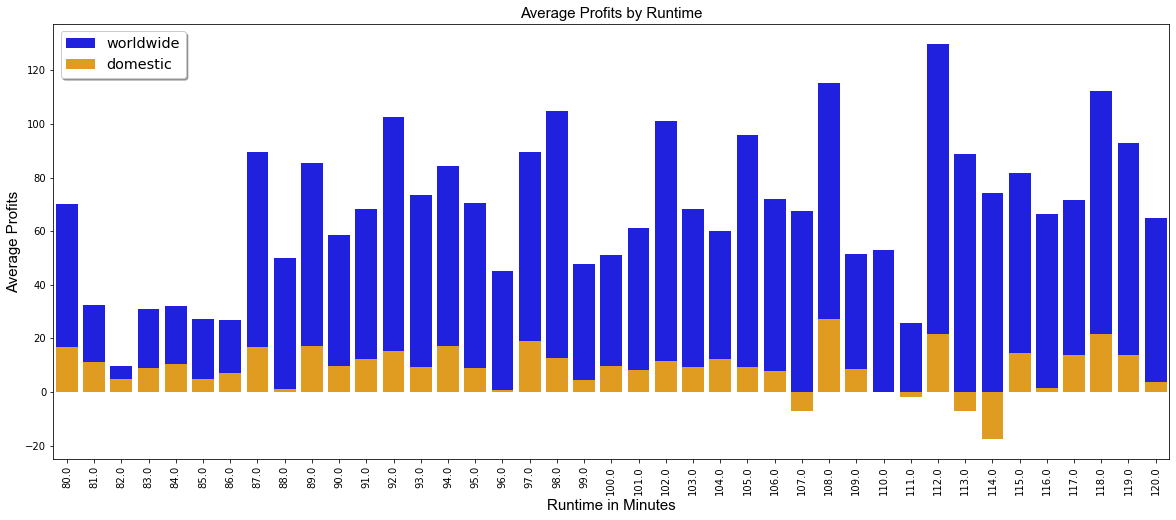

In [25]:
plt.figure(figsize=(20,8))
ax = sns.barplot(data=runtimes2010_quint, x="runtime_minutes", y="worldwideprofits_inmillions", label = "worldwide", color = "blue", ci=None)
sns.barplot(data=runtimes2010_quint, x="runtime_minutes", y="domesticprofits_inmillions", label = "domestic", color = "orange", ci=None)
ax.set_xlabel('Runtime in Minutes', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Runtime', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

plt.xticks(rotation=90)

plt.show()

DIRECTORS

In [26]:
directors = pd.read_sql("""
SELECT *
  FROM movie_basics as mb
  JOIN directors as d
    ON mb.movie_id = d.movie_id
  JOIN persons as p
    ON d.person_id = p.person_id

""", conn)

In [27]:
directors

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,person_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,nm0002411,nm0002411,Mani Kaul,1944.0,2011.0,"director,writer,actor"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291166,tt9916730,6 Gunn,6 Gunn,2017,116.0,None,tt9916730,nm10538612,nm10538612,Kiran Gawade,NaN,NaN,None
291167,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,tt9916754,nm8349149,nm8349149,Vinicius Augusto Bozzo,1985.0,NaN,"writer,editor,director"
291168,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,tt9916754,nm8349149,nm8349149,Vinicius Augusto Bozzo,1985.0,NaN,"writer,editor,director"
291169,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,tt9916754,nm9272490,nm9272490,Angela Gurgel,NaN,NaN,"director,writer"


In [28]:
directors = pd.merge(directors, movie_gross, left_on ="primary_title", right_on ="movie", how = "outer")
directors=directors.drop(columns = ["movie_id", "original_title", "start_year", "runtime_minutes", 
                          "genres", "movie_id", "person_id", "person_id", "id", "movie", "worldwidegross_inmillions",
                          "domesticgross_inmillions", "productionbudget_inmillions", "year", "birth_year", "death_year",
                                   "primary_profession", "release_date"])
directors=directors.dropna(subset=["worldwideprofits_inmillions", "domesticprofits_inmillions", "primary_name"])
directors=directors.drop_duplicates()

In [29]:
directors_w = directors.drop(columns = ["primary_title", "domesticprofits_inmillions"]).groupby("primary_name").mean().reset_index()
directors_w = directors_w.sort_values(by="worldwideprofits_inmillions", ascending=False)
directors_w = directors_w.loc[directors_w["worldwideprofits_inmillions"]>0]
directors_w_top = directors_w.head(30)
directors_d = directors.drop(columns = ["primary_title", "worldwideprofits_inmillions"]).groupby("primary_name").mean().reset_index()
directors_d = directors_d.sort_values(by="domesticprofits_inmillions", ascending=False)
directors_d = directors_d.loc[directors_d["domesticprofits_inmillions"]>0]
directors_d_top=directors_d.head(30)

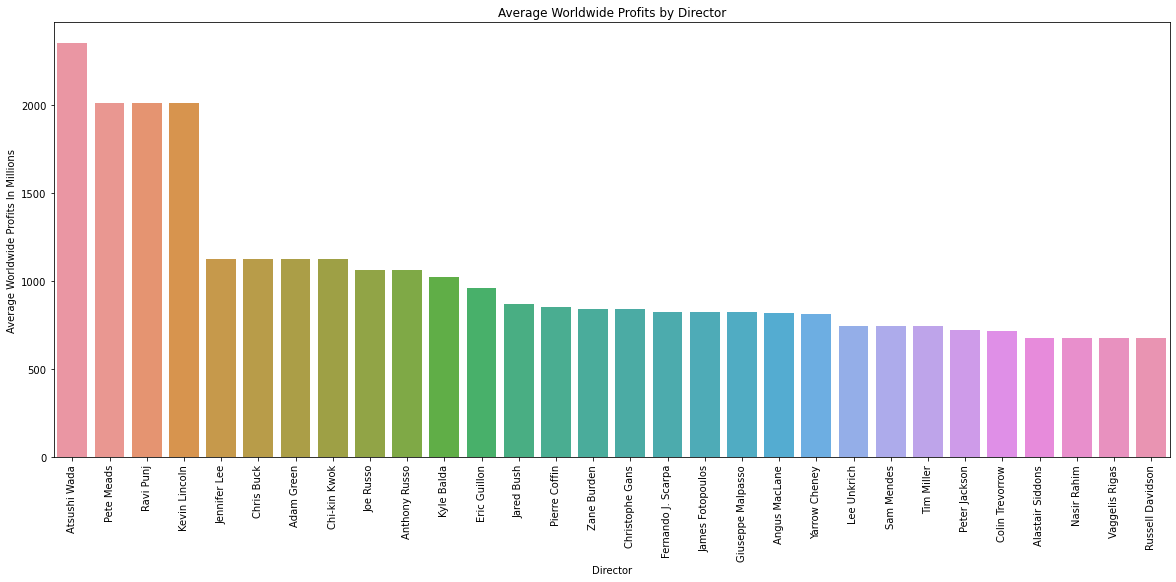

In [30]:
plt.figure(figsize=(20,8))
w=sns.barplot(data=directors_w_top, x="primary_name", y="worldwideprofits_inmillions", ci=None)
w.set(xlabel='Director',
       ylabel='Average Worldwide Profits In Millions',
       title='Average Worldwide Profits by Director')
plt.xticks(rotation=90)

plt.show()

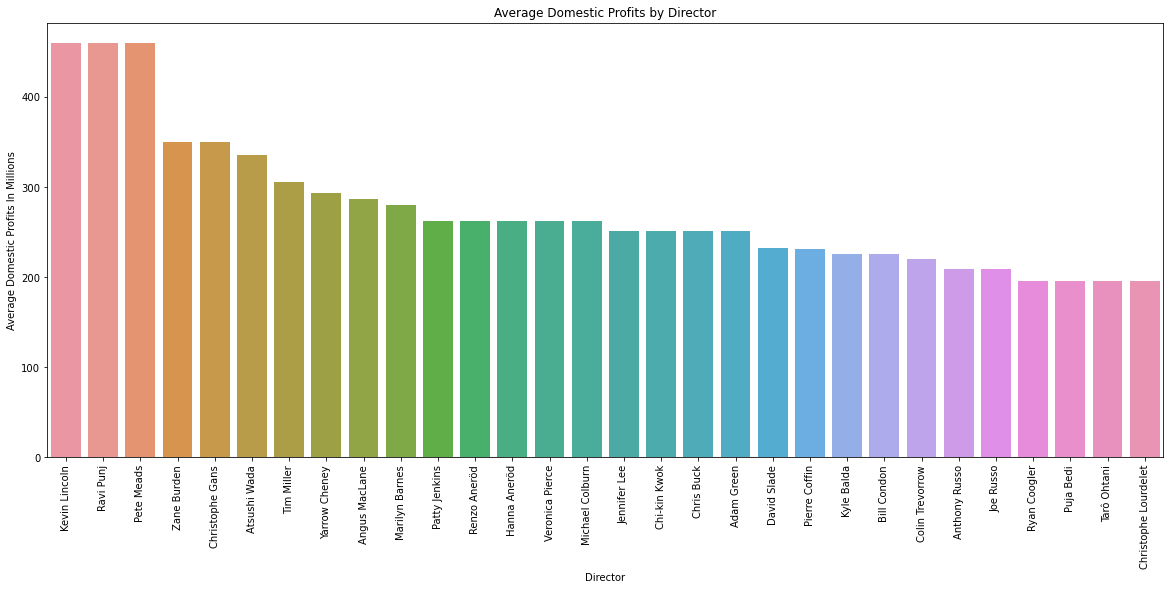

In [31]:
plt.figure(figsize=(20,8))
w=sns.barplot(data=directors_d_top, x="primary_name", y="domesticprofits_inmillions", ci=None)
w.set(xlabel='Director',
       ylabel='Average Domestic Profits In Millions',
       title='Average Domestic Profits by Director')
plt.xticks(rotation=90)

plt.show()